# Physionet ECG data exploration, clustering and prediction

## First and foremost, let's gather the imports

In [ ]:
# System tools
import os
import math
from pathlib import Path

# Physiolab libraries
import wfdb
import heartpy as hp

# Data management tools
import numpy as np
import pandas as pd

# Algorithms
from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix

# Visualization tools
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

#Auxiliary code
from feature_extraction import *

# Configurations
%matplotlib inline
from IPython.display import display
%load_ext autoreload
%autoreload 2


## Let's collect the data

Physionet is a large database repository for physiological signals.
 
"PhysioNet, the moniker of the Research Resource for Complex Physiologic Signals, was established in 1999 under the auspices of the National Institutes of Health (NIH) [...]"

PhysioNet is maintained by researchers and engineers at the MIT Laboratory for Computational Physiology.

In order to be able to use their data, it is convenient to maek use of their [wfdb](https://wfdb.readthedocs.io/en/latest/) python package:

"The native Python waveform-database (WFDB) package. A library of tools for reading, writing, and processing WFDB signals and annotations."

In [ ]:
samples_directory = 'ptb-diagnostic-ecg-database-1.0.0'
path_list = sorted(Path(samples_directory).glob('**/*.dat'))

# This will be our metadata dataframe
comments_df = pd.DataFrame()

# List containing the indexes of the different ECG leads. 
# For the sake of simplicity, we will focus in the vx, vy and vz time series
channels = [*range(0,15,1)] 

# Originally this number is larger in the dataset, but we will cap to 5000 points
max_samples = 5000 

signals_dfs_list = []

for path in path_list:

    patient_path = str(path).replace('.dat', '')
        
    record = wfdb.rdheader(patient_path)     
    comments_dict = dict([map(str.strip, i.split(':')[:2]) for i in record.comments])
    for key, value in comments_dict.items():
        comments_dict[key] = value
    df_dictionary = pd.DataFrame([comments_dict])
    comments_df = pd.concat([comments_df, df_dictionary], ignore_index=True)

    signals, fields = wfdb.rdsamp(patient_path, channels=channels, sampfrom=0, sampto=max_samples)
    record_signals_df = pd.DataFrame(columns=[record.sig_name[channel] for channel in channels], data=signals)
    record_signals_df['fs'] = fields['fs']
    
    signals_dfs_list.append(record_signals_df)


#### Prepare comments metadata

In [ ]:
# Let's create a new column collecting all the tokens
comments_df['text'] = comments_df.agg('-'.join, axis=1)

# The age data is better treated as a number
comments_df['age'] = comments_df['age'].replace('n/a','0').astype(float)

# Let's unify the n/a's and unknowns into a single value
comments_df = comments_df.replace('unknown','n/a')
display(comments_df.head())

#### Prepare ECG leads data

In [ ]:
# Finally, let's turn our list of dataframes into a more efficient numpy array
signals_array = np.stack(signals_dfs_list)
print(signals_array.shape)
#Finally, let's regularize our time series
for i in range(len(signals_dfs_list)):
    scaler = MinMaxScaler()
    signals_array[i] = MinMaxScaler().fit_transform(signals_array[i])
# Then, we can reshape it to better fit our feature extraction functions

num_patients = signals_array.shape[0]
num_samples = signals_array.shape[1]
num_leads = signals_array.shape[2]
signals_array = signals_array.reshape(num_leads, num_patients, num_samples)

print('Reshaped array dimensions:', signals_array.shape)

## Exploring patient metadata

Physionet data in this dataset separates data into lead signals and comments / metadata provided by the physicians.

Potentially, this seems like a good source for labelling somehow the predictions we want to may want to make, given the wealth of data it provides.

Let's try to get some useful and interesting insights about the patients and the structure of the metadata.

Interestingly, there is a "Smoker" parameter that tells us whether a person is addicted or not to tobacco.

In [ ]:
# Let's print out some facts about our metadata
print('We can split our population by age and whether they smoke or not')
display(comments_df[['age', 'Smoker']].value_counts(ascending=False, normalize=True))

print('List below represents the number of unique entries for each metadata')
comments_df.nunique()

We can also try and see some patterns by displaying data over time.
Colors represent age. Hovering the cursor over the points we can see the additional diagnoses field

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pd.to_datetime(comments_df['ECG date'], errors='coerce', infer_datetime_format=True),
                    y=comments_df['Reason for admission'],
                    mode='markers',
                    text=comments_df['Additional diagnoses'],
                    # Size by total population of each neighborhood. 
                    marker=dict(color=comments_df['age'].astype(float),
                                opacity=0.5)
))

fig.update_layout(
    title="ECG Date vs Reason for admission",
    xaxis_title="ECG Date",
    yaxis_title="Reason for admision",
)

fig.show()

### NLP for clustering

Using some of the above metadata, we can try to find hidden patterns into it by means of lemmatization of the aggregated text and PCA analysis of the resulting vector.
To learn more about it, visit https://sanjayasubedi.com.np/nlp/nlp-with-python-document-clustering/

The plan ahead is to see if we can group the comments into "Smokers" and non "Smokers" just by reading them (possibly not, but who knows)

In [ ]:
# Let's avoid giving too much information to the classifier by removing the column of study
comment_clustering = 'Smoker'
n_components = 2
random_state = 0

comments_df_tfidf = comments_df.drop([comment_clustering], axis=1)

vec = TfidfVectorizer(stop_words="english")
vec.fit(comments_df_tfidf.text.values)
nlp_features = vec.transform(comments_df_tfidf.text.values)

# reduce the features to 2D
pca = PCA(n_components=n_components, random_state=random_state)
reduced_features = pca.fit_transform(nlp_features.toarray())

Now that we have a simplified set of numerical variables, we can feed some classifier.

In order to simplify, let's use a MiniBatchKmeans 

In [ ]:
X = nlp_features
y = comments_df[comment_clustering].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

n_clusters = y.nunique()
label_names = comments_df[comment_clustering].unique()

cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
cls.fit(X_train)

y_pred = cls.predict(X_test)


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=reduced_features[:,0],
                    y=reduced_features[:,1],
                    mode='markers',
                    text=comments_df[comment_clustering],
                    # Size by total population of each neighborhood. 
                    marker=dict(size=comments_df['age'].astype(float),
                                sizemode='diameter',
                                color=cls.predict(nlp_features).astype(float),
                                sizeref=comments_df['age'].astype(float).max()/30,
                                opacity=0.5)
))

fig.update_layout(
    title="Comments metadata PCA Plot",
    xaxis_title="Component 1",
    yaxis_title="Component 2",
)


fig.show()

Well, this is not totally disappointing. 

We have used the prediction of the KMeans to color them, and the true label as a hover text. 

There seems to be some connection between them, being the "n/a" cluster the red on the right, most of the "yes" piling in yellow on the left and most of the "no" conforming the blue tip. 

Let's see this visually with a confusion matrix:

In [ ]:
cm = confusion_matrix(y_test, y_pred)
s = sns.heatmap(cm, annot=True, fmt='d', )
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)
s.set_title('Confusion matrix')

print('Total clusters:', n_clusters)
print('Total samples (support):', y_pred.shape[0])
print('Labels:', label_names)

Uh, oh, this confusion matrix doesn't look too good after all.

In [ ]:
print('Test set report')
print(classification_report(y_test, y_pred, target_names=label_names))


Actually, these results are pretty bad indeed. An F1-score that low is completely unacceptable.

Let's try better luck with the ECG time series!

## Exploring patients ECG leads data

### A primer on ECG leads

As explained [here](https://www.sciencedirect.com/science/article/abs/pii/S0733865106000208?via%3Dihub) (E. Trägårdh, H. Engblom, O. Pahlm, Cardiology clinics, Elsevier, 2006), "the number of leads used and the electrode placement in a standard ECG have remained the same for over half a century although the technology behind the method has developed greatly."

To my own surprise, the author explains that "It is well known that the sensitivities of current standard 12-lead ECG criteria for detecting many cardiac diseases—such as acute myocardial infarction (MI) and ventricular hypertrophy— **are poor**."

In order to understand the optimal number of inputs to be used, I have resourced to [this article](https://ecgwaves.com/topic/ekg-ecg-leads-electrodes-systems-limb-chest-precordial/#:~:text=The%2012%2Dlead%20ECG%20offers,using%20the%2012%2Dlead%20ECG.), where it is explained the high degree of correlation that exists between the different signals, as per Einthoven's law and Golderberg equations.

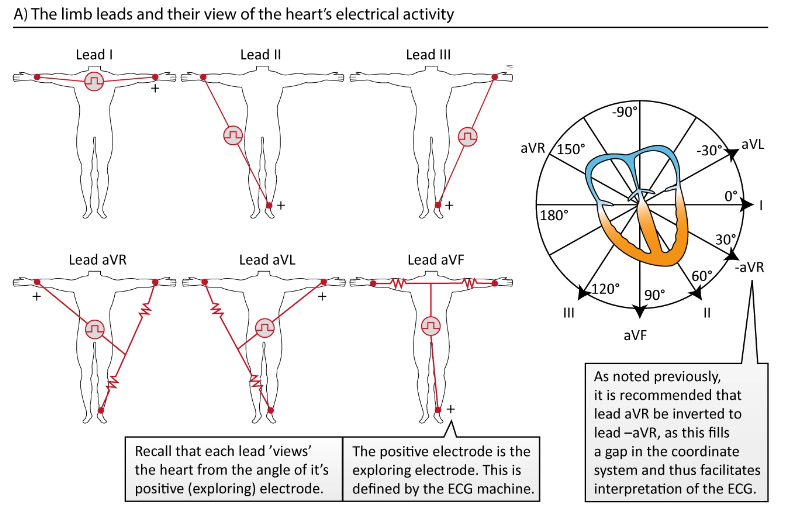


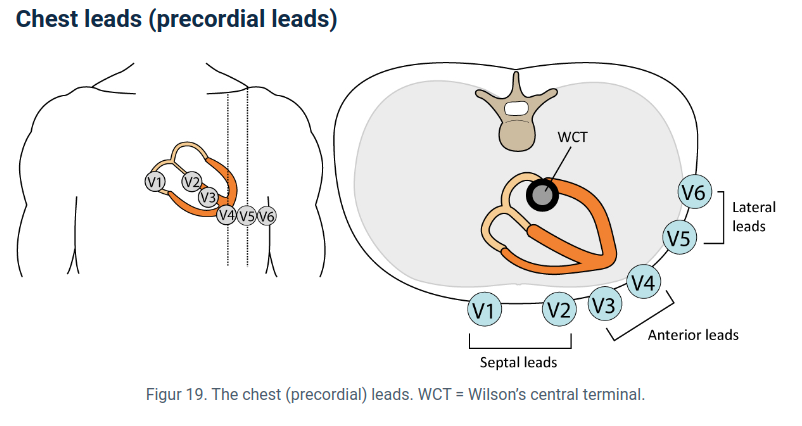

Source: ecgwaves.com


### Let's explore the lead signals for a single patient

In [ ]:
# We can collect all lead time series signals into a dataframe and see what data looks like
leads_df = signals_dfs_list[0]

# Now we can try and visualize them
fig = make_subplots(rows=len(channels), cols=1)

i=1

for column in leads_df.drop(['fs'], axis=1).columns:     

    fig.add_trace(
        go.Scatter(y=leads_df[column], text=column, name=column),
        row=i, col=1
    )

    i +=1

fig.update_layout(
    height=1000, 
    width=900,
    title=f"Sample {len(channels)} lead ECG (Patient01)",
    yaxis_title="Voltage",
)

fig.show()

Using the HeartPy module in Python, we can analyze the bpms

In [ ]:
sample_rate = leads_df['fs'].mean()


for column in leads_df.columns: 
    try:
        print('******************************')
        print('Lead = ', column)
        print('******************************')
        data = leads_df[column]
        plt.figure(figsize=(12,4))
        plt.plot(leads_df[column])
        plt.show()
        #run analysis
        wd, m = hp.process(data, sample_rate)

        #visualise in plot of custom size
        plt.figure(figsize=(12,4))
        hp.plotter(wd, m)

        #display computed measures
        for measure in m.keys():
            print('%s: %f' %(measure, m[measure]))
            print()
    except:
        print('Failed to get Heartbeat data for ' , column)

### QRS Complex analysis

From the above analysis, we can extract the bpm and other interesting clinical data.

Image below depicts a typical QRS complex fragment.

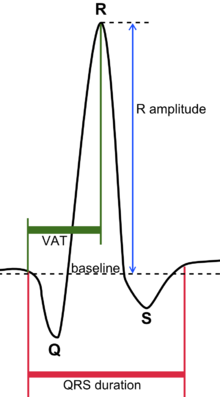

It might also be interesting to see how correlated the different leads are:

In [ ]:
df_corr = leads_df.drop(['fs'], axis=1).corr()
fig = go.Figure()
fig.add_trace(
    go.Heatmap(
        x = df_corr.columns,
        y = df_corr.index,
        z = np.array(df_corr),
        text=df_corr.values,
        texttemplate='%{text:.2f}'
    )
)

fig.update_layout(
    height=1000, 
    width=900,
    title=f"Sample {len(channels)} lead ECG correlation matrix (Patient01)",
    xaxis_title='Channel name',
    yaxis_title='Channel name',
)

fig.show()

From the above, we should be able to confirm **Einthoven's Law**: 

- Lead I + Lead III = Lead II

Lead I has nearly no correlation to Lead II (-7%)

Lead I has strong negative correlation to Lead III (75%)

Lead II has strong positive correlation to Lead III (71%)

And also **Goldberger's**:

- -aVR = (Lead I + Lead II) / 2
- aVL = (Lead I - Lead III) / 2
- aVF = (Lead II + Lead III) / 2

aVR has strong negative correlation to Lead I (71%) and Lead II (66%)

aVL has strong positive correlation to Lead I (91%) and negative to Lead III (96%)

aVF has strong positive correlation to Lead II (89%) and to Lead III (95%)

## Pattern finding in our time series

Once we know what kind of data we are dealing with, we can start to try finding ways to clusterize it and see what patterns emerge.

For the sake of simplycity, we will adhere only to the time series raw data, omitting the extra metrics provided by HeartPy.

But first things first, let's convert the time series signals into a feature vector with the feature extraction module. These functions (taken from [here](https://github.com/jeandeducla/ML-Time-Series) ) help us extract statistical and geometrical features from raw signals and jerk signals (acceleration first derivative), frequency domain features from raw signals and jerk signals 

### Dimension reduction with feature extraction

In [ ]:
lead_features = make_feature_vectors(signals_array)

In [ ]:
X = lead_features
y = comments_df[comment_clustering].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size = .75)

cls = MiniBatchKMeans(n_clusters=n_clusters, random_state=random_state)
cls.fit(X_train)

# predict cluster labels for new dataset
y_pred = cls.predict(X_test)

# reduce the features to 2D
pca = PCA(n_components=n_components, random_state=random_state)
reduced_features = pca.fit_transform(lead_features)

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=reduced_features[:,0],
                    y=reduced_features[:,1],
                    mode='markers',
                    text=comments_df[comment_clustering],
                    # Size by total population of each neighborhood. 
                    marker=dict(size=comments_df['age'].astype(float),
                                sizemode='diameter',
                                color=cls.predict(lead_features).astype(float),
                                sizeref=comments_df['age'].astype(float).max()/30,
                                opacity=0.5)
))


fig.update_layout(
    title="PCA Plot of ECG Lead time series",
    xaxis_title="Component 1",
    yaxis_title="Component 2",
)

fig.show()

In [ ]:
cm = confusion_matrix(y_test, y_pred)
s = sns.heatmap(cm, annot=True, fmt='d', )
s.set_xlabel('Predicted', fontsize=10)
s.set_ylabel('True', fontsize=10)
s.set_title('Confusion matrix')

print('Total clusters:', n_clusters)
print('Labels:', label_names)

In [ ]:
print('Test set report')
print(classification_report(y_test, y_pred, target_names=label_names))

# Conclusion and further work

A set of techniques has been demonstrated in order to find order in a public Physiological dataset with 549 entries.

These entries come structured into several parts, but we took the Annotation and the ECG time series to try to fit a KMeans estimator that would serve us identify smoking habits out of either the doctor notes or the ECG signals

In both attempts, the accuracy of the model has proven to be very low, despite the fact that PCA plots show sme degree of clusterization.

Most likely, the choice of the "Smoker" feature was not a good one.

In the future, it would be interesting to replace the feature vector extracted by means of "traditional" signal processing with the data provided by the HeartPy module.

Another interesting line of research would be to use transfer learning with a newly defined re-dimensioned dataset in project such as this: 

- https://www.kaggle.com/datasets/shayanfazeli/heartbeat/code
